# Introduction

The objective of this project is to develop a predictive model that estimates the mortality risk of patients based on their clinical data. Such a tool can assist doctors in making informed decisions about whether a patient requires hospitalization or can be safely discharged. In addition to providing accurate predictions, the project emphasizes interpretability: by identifying which features contribute most to the risk assessment, we aim to highlight the clinical factors that deserve the closest attention.

# Import libraries

In [426]:
import pandas as pd 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from xgboost import XGBClassifier

In [427]:
import importlib
import models 
import preprocessing

importlib.reload(models)
importlib.reload(preprocessing)
from models import logistic_regression, display_metrics, display_metrics_logistic_regression_k_times, display_metrics_xgboost_k_times, display_metrics_knn_k_times
from preprocessing import preprocess_data, fillna_and_encode

# Import df

In [428]:
df = pd.read_csv('support2.csv')

In [429]:
(df.isna().sum() / len(df)).sort_values(ascending=False).head(10)

adlp       0.619550
urine      0.533992
glucose    0.494234
bun        0.477979
totmcst    0.381658
alb        0.370346
income     0.327512
adls       0.314882
bili       0.285667
pafi       0.255354
dtype: float64

# X, y 

In [430]:
X = df.drop(columns=["hospdead"])
y = df["hospdead"]

# First dataframe

## Preprocessing

These columns are deleted cause or they contains too much missing values or they say to us too much information (d.time say if the patient died or not for instance)

In [431]:
columns_to_drop = [
    "aps", "sps", "surv2m", "surv6m", "prg2m", "prg6m",
    "dnr", "dnrday", "slos", "death", "d.time", "adls", "adlp",
    "dzclass", "scoma", "hday", "totcst", "charges", "totmcst"
]

X1 = X.drop(columns=columns_to_drop)

In [432]:
(X1.isna().sum() / len(X1)).sort_values(ascending=False).head(10)

urine      0.533992
glucose    0.494234
bun        0.477979
alb        0.370346
income     0.327512
bili       0.285667
pafi       0.255354
ph         0.250851
edu        0.179462
sfdm2      0.153762
dtype: float64

The author of the paper the dataset is originated from explains that for certains columns we can replace missing values by default values

In [433]:
X1.fillna({
    "bun": 6.51,
    "pafi": 333.3,
    "alb": 3.5,
    "bili": 1.01,
    "wblc": 9,
    "urine": 2502,
    "crea": 1.01
}, inplace=True)


In [434]:
(X1.isna().sum() / len(X1)).sort_values(ascending=False).head(10)

glucose    0.494234
income     0.327512
ph         0.250851
edu        0.179462
sfdm2      0.153762
avtisst    0.009006
race       0.004613
meanbp     0.000110
resp       0.000110
hrt        0.000110
dtype: float64

We will delete the following columns because they contain too much missing values : glucose, income

In [435]:
X1.drop(columns=["glucose", "income"], inplace=True)

In [436]:
(X1.isna().sum() / len(X1)).sort_values(ascending=False).head(10)

ph         0.250851
edu        0.179462
sfdm2      0.153762
avtisst    0.009006
race       0.004613
hrt        0.000110
meanbp     0.000110
sod        0.000110
temp       0.000110
resp       0.000110
dtype: float64

In [438]:
(X1.isna().sum() / len(X1)).sort_values(ascending=False).head(10)

ph         0.250851
edu        0.179462
sfdm2      0.153762
avtisst    0.009006
race       0.004613
hrt        0.000110
meanbp     0.000110
sod        0.000110
temp       0.000110
resp       0.000110
dtype: float64

Now we are going to see how to replace missing values 

In [439]:
categorical_variables = [
    "diabetes","dementia","sex","race","dzgroup","ca","sfdm2","num.co", "edu"
]

In [440]:
X1_categorical = X1[categorical_variables]
X1_numerical = X1.drop(columns=categorical_variables)

For categorical, we are going to replace missing values with the most present category.

For numerical, we are going to replace missing valeus with the mean. 

In [ ]:

for col in X1_categorical.columns:
    # Find the most frequent value in the column
    most_frequent = X1_categorical[col].value_counts().idxmax()
    # Fill NaNs with the most frequent value
    X1_categorical[col] = X1_categorical[col].fillna(most_frequent)

X1_categorical = pd.get_dummies(X1_categorical, drop_first=True)


/tmp/ipykernel_655/756939678.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X1_categorical[col].fillna(most_frequent, inplace=True)
/tmp/ipykernel_655/756939678.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X1_categorical[col].fillna(most_frequent, inplace=True)
/tmp/ipykernel_655/756939678.py:5: FutureWarning: A value is trying to 

In [ ]:
X1_categorical.isna().sum().sum()  

0

### Dealing with numerical missing values with the mean

In [443]:
X1_numerical.fillna(df.mean(numeric_only=True), inplace=True)

In [ ]:
X1_numerical.isna().sum().sum() 

0

For better performance of models, we scale the numerical values

In [445]:
sc = StandardScaler()
X1_numerical = pd.DataFrame(
    sc.fit_transform(X1_numerical),
    columns=X1_numerical.columns,
    index=X1_numerical.index 
)


In [ ]:
X1_numerical.isna().sum().sum() 

0

In [447]:
X1_numerical.shape

(9105, 16)

In [448]:
X1_categorical.shape

(9105, 22)

pb decalage d'indice


### Merging

In [449]:
X1_cleaned = pd.concat([X1_numerical, X1_categorical], axis=1)

No more missing values

In [450]:
X1_cleaned.isna().sum().sum()  # Check if there are any remaining missing values

0

## Models

### Logistic regression

In [231]:
display_metrics_logistic_regression_k_times(X1_cleaned, y, k=5)

Accuracy: 0.890 ± 0.007 (SD over 5 runs)
Precision: 0.802 ± 0.020 (SD over 5 runs)
Recall: 0.770 ± 0.015 (SD over 5 runs)
F1 Score: 0.786 ± 0.012 (SD over 5 runs)


We can conclude than the model does not rely too much on the data and does not overfit, therefore to see which features matter the most, we are going to use the prediction for one X_train, y_train, X_test, y_test

#### Analysis

In [451]:
X_train, X_test, y_train, y_test = train_test_split(X1_cleaned, y, test_size=0.2)
LR, y_pred = logistic_regression(X_train, X_test, y_train)

Accuracy: 0.89
Precision: 0.81
Recall: 0.78
F1 Score: 0.79


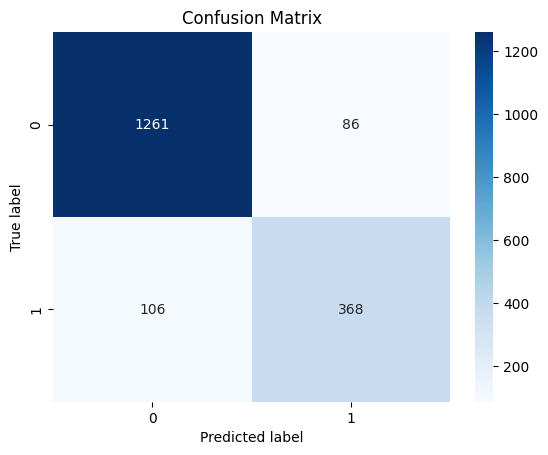

In [246]:
display_metrics(y_test, y_pred)

In [ ]:
coefs = LR.coef_[0]

feature_names = X_train.columns

# Here we create a DataFrame to hold feature names and their corresponding coefficients
importance = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs,
    "abs_coefficient": np.abs(coefs),
    "odds_ratio": np.exp(coefs)
}).sort_values("abs_coefficient", ascending=False)

top_features = importance.head(15)

plt.figure(figsize=(8,6))
plt.barh(top_features['feature'], top_features['abs_coefficient'])
plt.xlabel("Abs Coefficient (log-odds)")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances in Logistic Regression")
plt.gca().invert_yaxis()  # highest coefficient on top
plt.tight_layout()
plt.show()

What we can first see is that the initial variable sfdm2 (corresponding to the degree of disability of the patient) is the most important, followed by avtisst (corresponding to an estimation of the cost of the patient's treatment)

### Random forest

In [ ]:
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions={
        'n_estimators': [50, 100, 200, 300, 400, 500],
        'max_depth': [None, 5, 10, 15, 20, 25, 30],

    },
    n_iter=20,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
    )

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)


best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)
display_metrics(y_test, y_pred)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Accuracy: 0.89
Precision: 0.83
Recall: 0.73
F1 Score: 0.78


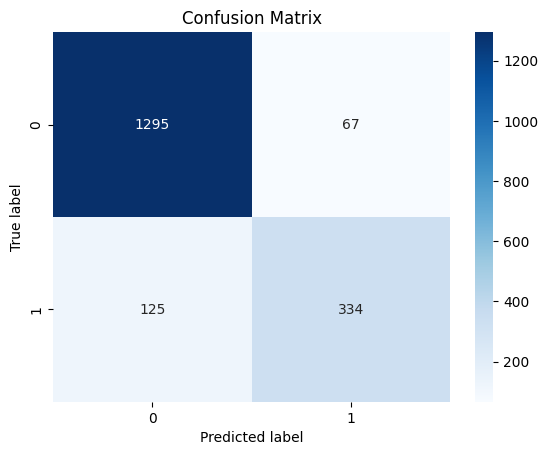

In [452]:
# Initialize and train Random Forest
rf = RandomForestClassifier(
    n_estimators=500,  # number of trees
    max_depth=None,    # allow full growth
    random_state=42,
    n_jobs=-1          # use all CPUs
)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Optional: check accuracy
display_metrics(y_test, y_pred)

#### Analysis

In [254]:
importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": rf.feature_importances_
}).sort_values("coefficient", ascending=False)

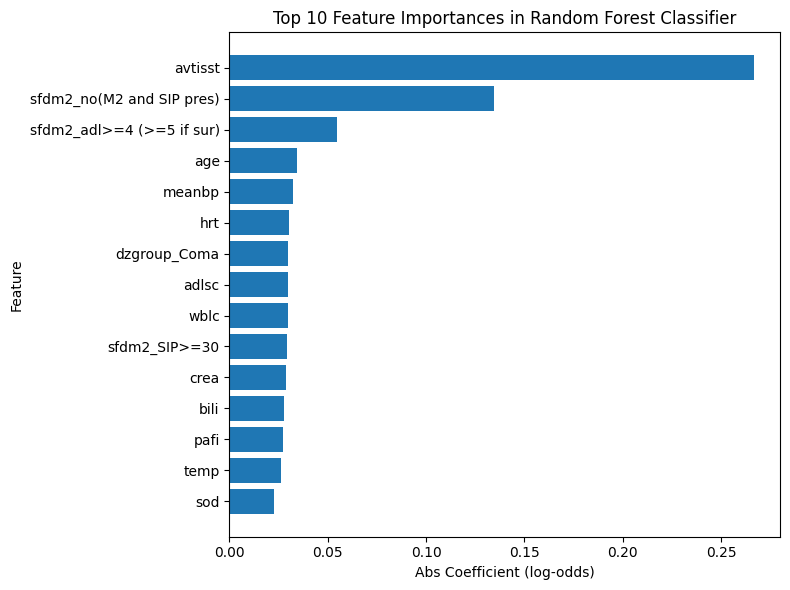

In [257]:
top_features = importance_df.head(15)

plt.figure(figsize=(8,6))
plt.barh(top_features['feature'], top_features['coefficient'])
plt.xlabel("Abs Coefficient (log-odds)")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances in Random Forest Classifier")
plt.gca().invert_yaxis()  # highest coefficient on top
plt.tight_layout()
plt.show()

Here for the random classifier, avtisst is the most important variable

##### Shap

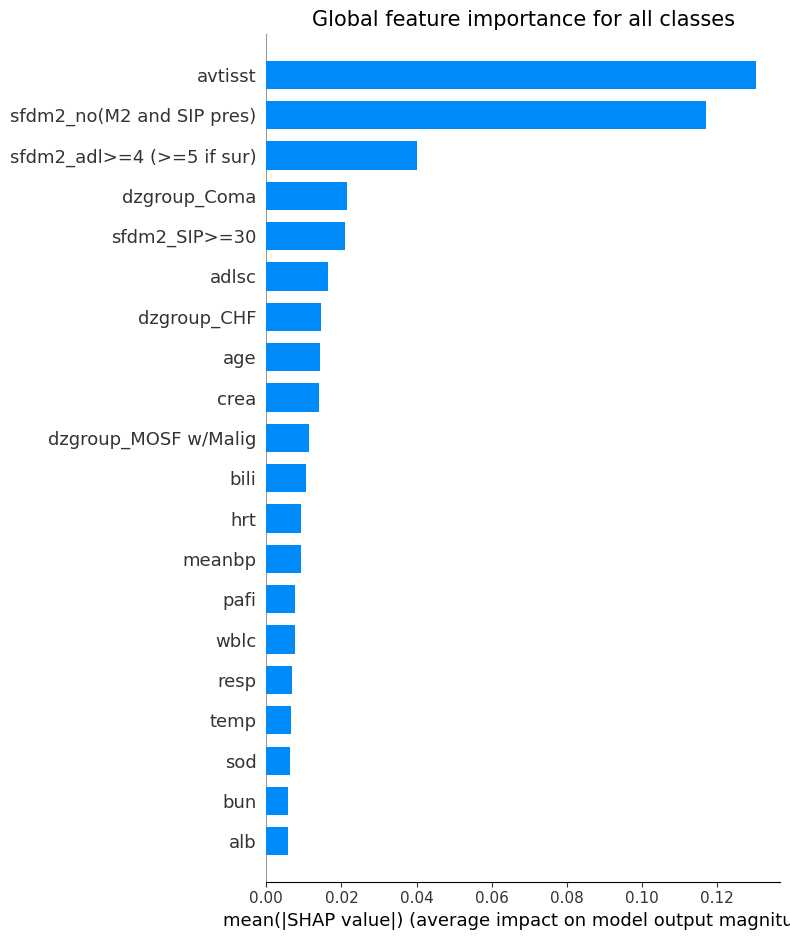

In [260]:
explainer = shap.TreeExplainer(rf)

shap_values = explainer.shap_values(X_train)

# Average SHAP values across classes (for multi-class classification)
shap_values_mean = np.abs(shap_values).mean(axis=2)

# Plot global feature importance for all classes
plt.title("Global feature importance for all classes", fontsize=15)
shap.summary_plot(shap_values_mean, X_train, feature_names=X_train.columns, plot_type="bar")



##### Permutation importance

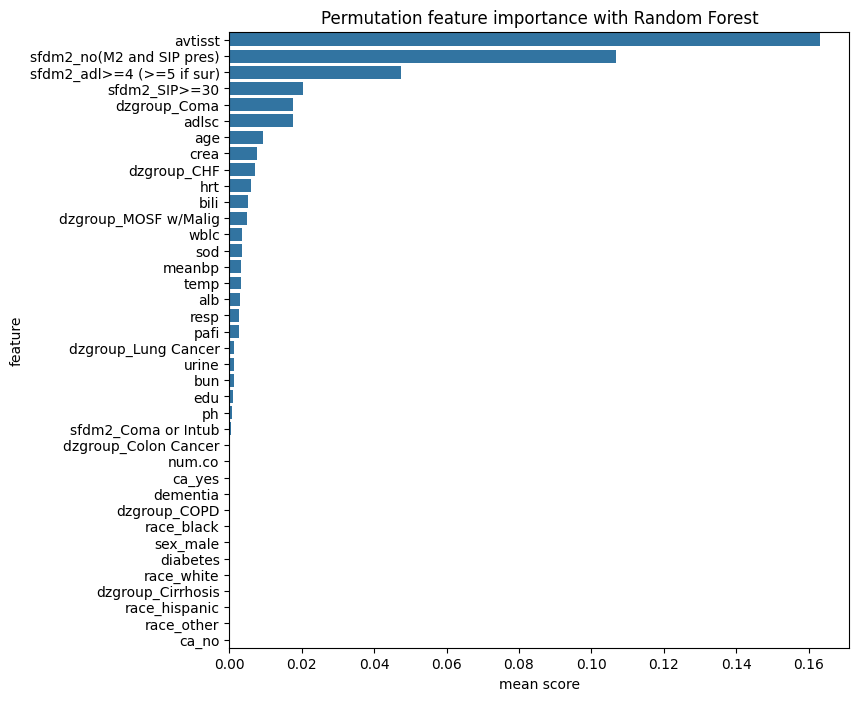

In [263]:
from sklearn.inspection import permutation_importance

# Compute permutation importance for each feature using an accuracy score
permutation_score = permutation_importance(rf, X_train, y_train, n_repeats=30, scoring="accuracy", random_state=0) # n_repeats: number of times data is reshuffled

# Create dataframe
permutation_df = pd.DataFrame({"feature":X_train.columns,
                               "mean score":permutation_score.importances_mean,
                               "std":permutation_score.importances_std}).sort_values("mean score", ascending=False)


plt.figure(figsize=(8,8))
sns.barplot(data = permutation_df, x="mean score", y="feature")
plt.title("Permutation feature importance with Random Forest")
plt.show()

In [251]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)

Best Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Estimator: RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5)


Accuracy: 0.89
Precision: 0.83
Recall: 0.75
F1 Score: 0.79


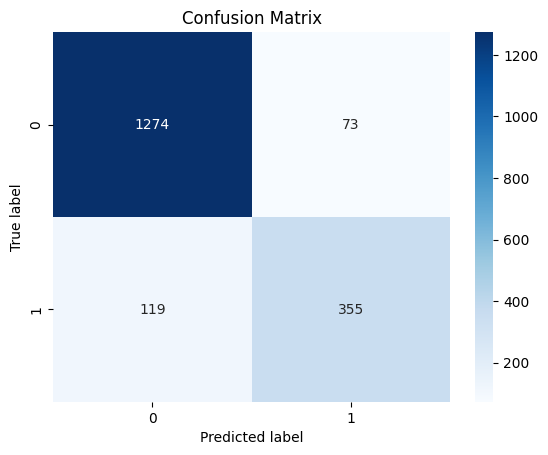

In [ ]:
# Initialize and train Random Forest
rf = RandomForestClassifier(
    n_estimators=500,  # number of trees
    max_depth=None,    # allow full growth
    random_state=42,
    n_jobs=-1,
    min_samples_split=5       # use all CPUs
)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Optional: check accuracy
display_metrics(y_test, y_pred)

### XGBoost

Here, we are going to use a RandomizedSearchCV to get the best hyperparameters for our xgboost model

In [290]:

xgb_clf = XGBClassifier(
    random_state=100,
    eval_metric='logloss'
)


param_grid = {
    "n_estimators": [100, 200, 300, 400, 500],
    "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# Randomized search with 5-fold CV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=250,          # here we choose a big number to try a lot of combinations 
    scoring="f1",        
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=100
)

# Fit random search
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best F1 score:", random_search.best_score_)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


Best parameters: {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.02, 'colsample_bytree': 0.6}
Best F1 score: 0.7825543261916297


Here are the best parameters

In [453]:
bp = random_search.best_params_
subsample = bp['subsample']
colsample_bytree = bp['colsample_bytree']
n_estimators = bp['n_estimators']
learning_rate = bp['learning_rate']
max_depth = bp['max_depth']

Accuracy: 0.89
Precision: 0.8
Recall: 0.75
F1 Score: 0.77


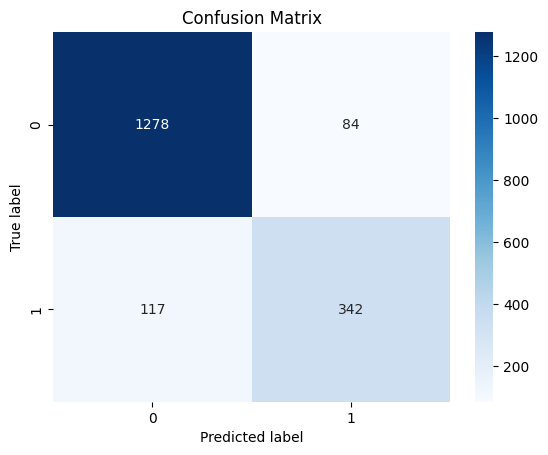

In [454]:
# Define model
xgb_clf = XGBClassifier(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,          
    subsample=subsample,       
    colsample_bytree=colsample_bytree, 
    random_state=100,
    eval_metric='logloss' 
)

# Fit model
xgb_clf.fit(X_train, y_train)

# Predict
y_pred = xgb_clf.predict(X_test)

display_metrics(y_test, y_pred)


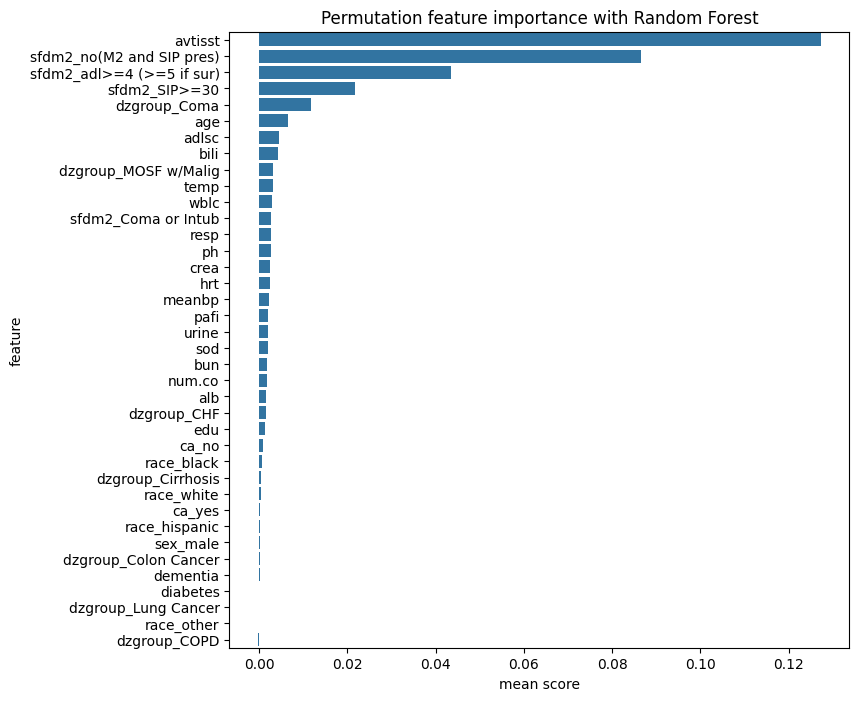

In [ ]:


# Compute permutation importance for each feature using an accuracy score
permutation_score = permutation_importance(xgb_clf, X_train, y_train, n_repeats=30, scoring="accuracy", random_state=0)

# Create dataframe
permutation_df = pd.DataFrame({"feature":X_train.columns,
                               "mean score":permutation_score.importances_mean,
                               "std":permutation_score.importances_std}).sort_values("mean score", ascending=False)


plt.figure(figsize=(8,8))
sns.barplot(data = permutation_df, x="mean score", y="feature")
plt.title("Permutation feature importance with XGBoost")
plt.show()

We obtain again sfdm2 different categories and avtisst as the features that matter the most.

### KNN

Accuracy: 0.79
Precision: 0.62
Recall: 0.47
F1 Score: 0.53


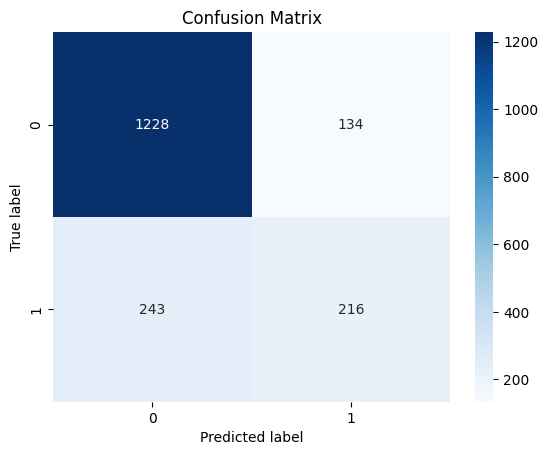

In [455]:

knn = KNeighborsClassifier(n_neighbors=3, weights='distance')

knn.fit(X_train, y_train)   

y_pred = knn.predict(X_test)     


display_metrics(y_test, y_pred)

### Comparison

In [456]:
classifiers = {"knn" : knn,
               "logistic_regression" : LR,
               "random_forest" : rf,
               "xgboost_classifier" : xgb_clf}

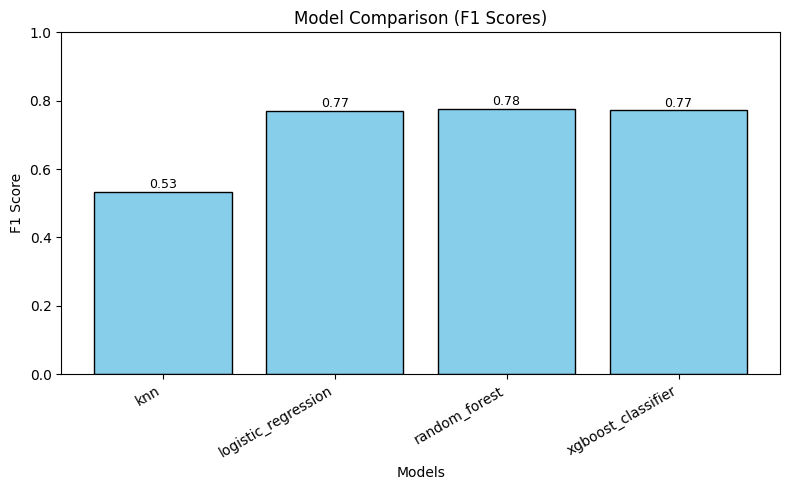

In [458]:
f1_scores = {}
for name, clf in classifiers.items():
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores[name] = f1


# Extract keys and values
models = list(f1_scores.keys())
scores = list(f1_scores.values())

# Plot
plt.figure(figsize=(8, 5))
plt.bar(models, scores, color="skyblue", edgecolor="black")

# Add labels and title
plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.title("Model Comparison (F1 Scores)")
plt.ylim(0, 1)  # since F1 scores go from 0 to 1
plt.xticks(rotation=30, ha="right")

# Annotate bars with values
for i, v in enumerate(scores):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center", fontsize=9)

plt.tight_layout()
plt.show()

# Second dataframe

For this one, we will try to work more on the data we have

In [315]:
X2 = X

## Preprocessing

For this df, we decide to to gather the features edu and age by group instead of having long int

In [341]:
X2 = preprocess_data(X2)

### Age

In [342]:
X2["age"].describe()

count    9105.000000
mean       62.650823
std        15.593710
min        18.041990
25%        52.797000
50%        64.856990
75%        73.998960
max       101.847960
Name: age, dtype: float64

In [343]:
# Define bins
bins = [0, 30, 40, 50, 60, 70, 80, 90, float("inf")]
labels = ["0-30", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90+"]

# Apply binning
X2["age_group"] = pd.cut(X2["age"], bins=bins, labels=labels, right=False)

### Edu

In [ ]:
# Define bins and labels
bins = [0, 5, 8, 13, 16, 18, 22, 30]  # edges in years
labels = [
    "Pre-school / early years",
    "Middle school",
    "High school",
    "Associate degree / some college",
    "Bachelor's degree",
    "Master's degree",
    "Doctorate / Professional degree"
]

X2["edu_group"] = pd.cut(X2["edu"], bins=bins, labels=labels, right=False)


In [349]:
X2.drop(columns=["age", "edu"], inplace=True)

### Categorical variables 2

In [358]:
categorical_variables2 = [
    "diabetes","dementia","sex","race","dzgroup","ca","sfdm2","num.co", "age_group", "edu_group"
]

X2_cleaned = fillna_and_encode(X2,categorical_variables2)

In [359]:
display_metrics_logistic_regression_k_times(X2_cleaned, y, k=5)

Accuracy: 0.887 ± 0.007 (SD over 5 runs)
Precision: 0.792 ± 0.016 (SD over 5 runs)
Recall: 0.753 ± 0.023 (SD over 5 runs)
F1 Score: 0.772 ± 0.019 (SD over 5 runs)


## X, y

In [363]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_cleaned, y, test_size=0.2)

## Models

Accuracy: 0.88
Precision: 0.81
Recall: 0.7
F1 Score: 0.75


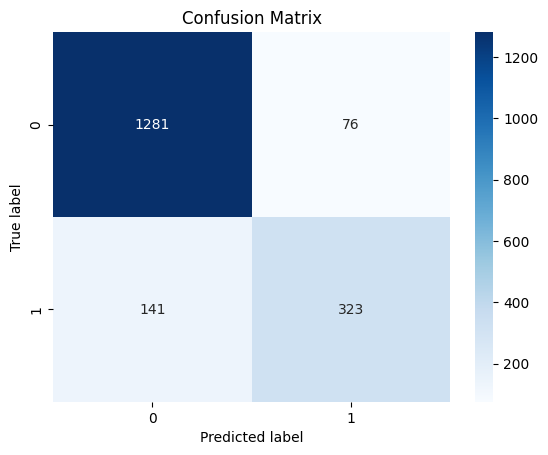

In [364]:
# Initialize and train Random Forest
rf = RandomForestClassifier(
    n_estimators=500,  # number of trees
    max_depth=None,    # allow full growth
    random_state=42,
    n_jobs=-1          # use all CPUs
)
rf.fit(X2_train, y2_train)

# Predict
y2_pred = rf.predict(X2_test)

# Optional: check accuracy
display_metrics(y2_test, y2_pred)

In [365]:

xgb_clf = XGBClassifier(
    random_state=100,
    eval_metric='logloss'
)


param_grid = {
    "n_estimators": [100, 200, 300, 400, 500],
    "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    "max_depth": [3, 4, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# Randomized search with 5-fold CV
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=250,          # here we choose a big number to try a lot of combinations 
    scoring="f1",        
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=100
)

# Fit random search
random_search.fit(X2_train, y2_train)

print("Best parameters:", random_search.best_params_)
print("Best F1 score:", random_search.best_score_)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.09, 'colsample_bytree': 0.8}
Best F1 score: 0.7907348100327635
